In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

# WiDS Datathon 2025: ADHD and Sex Prediction

**Goal:** Build a multi-outcome model to predict:
1. ADHD diagnosis (ADHD_Outcome: 0=Other/None, 1=ADHD)
2. Sex (Sex_F: 0=Male, 1=Female)

**Note:** Female ADHD cases are weighted 2x in evaluation

## Data Loading and Preprocessing

In [4]:
# Update these paths to your data location
base_path = "/Users/ashly/Desktop/widsdata"
train_cat = pd.read_csv(os.path.join(base_path, 'TRAIN_CATEGORICAL_METADATA_new.csv'))
train_fcm = pd.read_csv(os.path.join(base_path, 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv'))
train_quant = pd.read_csv(os.path.join(base_path, 'TRAIN_QUANTITATIVE_METADATA_new.csv'))

# Load the training solutions file
train_solution = pd.read_csv("C:/Users/ashly/Desktop/widsdata/TRAINING_SOLUTIONS.csv")
# Verify the contents
print("Training solutions columns:", train_solution.columns.tolist())
print("\nFirst few rows of training solutions:")
print(train_solution.head())

# Display initial shapes
print("Initial data shapes:")
print(f"Categorical data: {train_cat.shape}")
print(f"FCM data: {train_fcm.shape}")
print(f"Quantitative data: {train_quant.shape}")

Training solutions columns: ['participant_id', 'ADHD_Outcome', 'Sex_F']

First few rows of training solutions:
  participant_id  ADHD_Outcome  Sex_F
0   UmrK0vMLopoR             1      1
1   CPaeQkhcjg7d             1      0
2   Nb4EetVPm3gs             1      0
3   p4vPhVu91o4b             1      1
4   M09PXs7arQ5E             1      1
Initial data shapes:
Categorical data: (1213, 10)
FCM data: (1213, 19901)
Quantitative data: (1213, 19)


In [5]:
# Categorical Data Overview
train_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [6]:
# Functional Connectome Matrices Overview
train_fcm.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


In [7]:
# Quantitative Data Overview
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [8]:
# Data Merging
    # Merge the three datasets using participant_id

# First merge: Categorical and FCM data
merged_data = pd.merge(train_cat, train_fcm, on='participant_id', how='inner')
print(f"After first merge: {merged_data.shape}")

# Second merge: Add quantitative data
merged_data = pd.merge(merged_data, train_quant, on='participant_id', how='inner')
print(f"After second merge: {merged_data.shape}")

# Display Merged Data Overview
merged_data.head()

After first merge: (1213, 19910)
After second merge: (1213, 19928)


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [9]:
# Merge solutions with our feature data
merged_data_with_targets = pd.merge(
    merged_data, 
    train_solution[['participant_id', 'ADHD_Outcome', 'Sex_F']], 
    on='participant_id',
    how='inner'
)

analysis_data = pd.merge(
        merged_data,
        train_solution[['participant_id', 'ADHD_Outcome', 'Sex_F']],
        on='participant_id',
        how='inner'
    )

## Data Exploration and Verification
Check for missing values and data distribution

In [11]:
# Check missing values
missing_values = merged_data.isnull().sum()
missing_percentages = (missing_values / len(merged_data)) * 100

# Display columns with missing values and their percentages
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentages
})
missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage Missing', ascending=False)

print("Columns with missing values:")
print(missing_info)

Columns with missing values:
                                  Missing Values  Percentage Missing
MRI_Track_Age_at_Scan                        360           29.678483
Barratt_Barratt_P2_Occ                       222           18.301731
Barratt_Barratt_P2_Edu                       198           16.323166
PreInt_Demos_Fam_Child_Race                   54            4.451772
PreInt_Demos_Fam_Child_Ethnicity              43            3.544930
Barratt_Barratt_P1_Occ                        31            2.555647
ColorVision_CV_Score                          23            1.896125
Barratt_Barratt_P1_Edu                        15            1.236603
EHQ_EHQ_Total                                 13            1.071723
APQ_P_APQ_P_PM                                12            0.989283
APQ_P_APQ_P_PP                                12            0.989283
APQ_P_APQ_P_OPD                               12            0.989283
APQ_P_APQ_P_INV                               12            0.989283
APQ_P

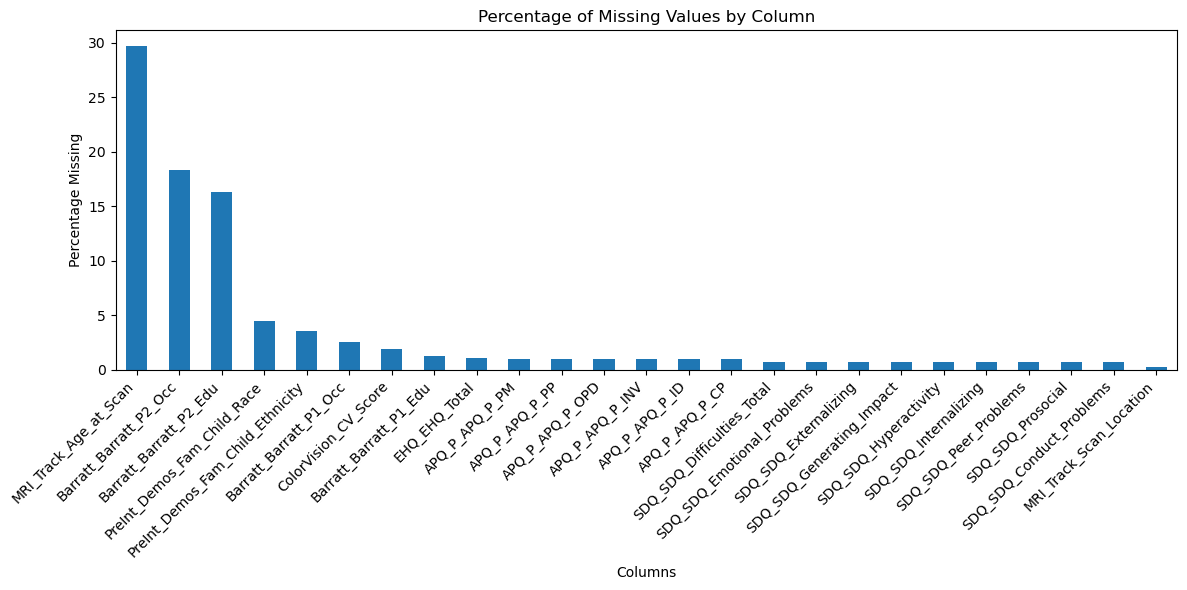

In [12]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_info['Percentage Missing'].plot(kind='bar')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
# --- Handle Missing Values ---
# Option 1: Drop columns with high percentage of missing values
high_missing_threshold = 10  # 30% threshold
columns_to_drop = missing_info[missing_info['Percentage Missing'] > high_missing_threshold].index.tolist()

print(f"\nDropping {len(columns_to_drop)} columns with more than {high_missing_threshold}% missing values:")
print(columns_to_drop)

merged_data_cleaned = merged_data.drop(columns=columns_to_drop)


Dropping 3 columns with more than 10% missing values:
['MRI_Track_Age_at_Scan', 'Barratt_Barratt_P2_Occ', 'Barratt_Barratt_P2_Edu']


In [14]:
def analyze_correlations(data, target_col, n_features=10):
    """
    Analyze and visualize correlations with target variable
    """
    # Handle missing values in numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    numeric_data = numeric_data.fillna(numeric_data.median())
    
    # Calculate correlations
    correlations = numeric_data.corrwith(numeric_data[target_col])
    correlations = correlations.drop(target_col)  # Remove self-correlation
    correlations = correlations.sort_values(ascending=False)
    
    # Visualize top positive and negative correlations
    plt.figure(figsize=(12, 6))
    
    # Select top and bottom correlations
    top_bottom_corr = pd.concat([
        correlations.head(n_features),
        correlations.tail(n_features)
    ])
    
    # Create barplot
    sns.barplot(x=top_bottom_corr.values, 
                y=top_bottom_corr.index, 
                palette="coolwarm")
    plt.title(f"Top {n_features} Positive and Negative Correlations with {target_col}")
    plt.xlabel("Correlation Coefficient")
    plt.tight_layout()
    plt.show()
    
    return correlations

In [15]:
def analyze_mutual_information(data, target_col, n_features=20):
    """
    Analyze mutual information between features and target
    """
    # Prepare data
    X = data.copy()
    y = X.pop(target_col)
    
    # Handle missing values
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
    
    # Handle categorical columns
    for colname in X.select_dtypes("object"):
        X[colname] = X[colname].fillna(X[colname].mode()[0])
        X[colname], _ = X[colname].factorize()
    
    # Calculate MI scores
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    # Visualize top MI scores
    plt.figure(figsize=(12, 6))
    sns.barplot(x=mi_scores.head(n_features).values,
                y=mi_scores.head(n_features).index,
                palette="viridis")
    plt.title(f"Top {n_features} Features by Mutual Information with {target_col}")
    plt.xlabel("Mutual Information Score")
    plt.tight_layout()
    plt.show()
    
    return mi_scores


Calculating mutual information for ADHD prediction...


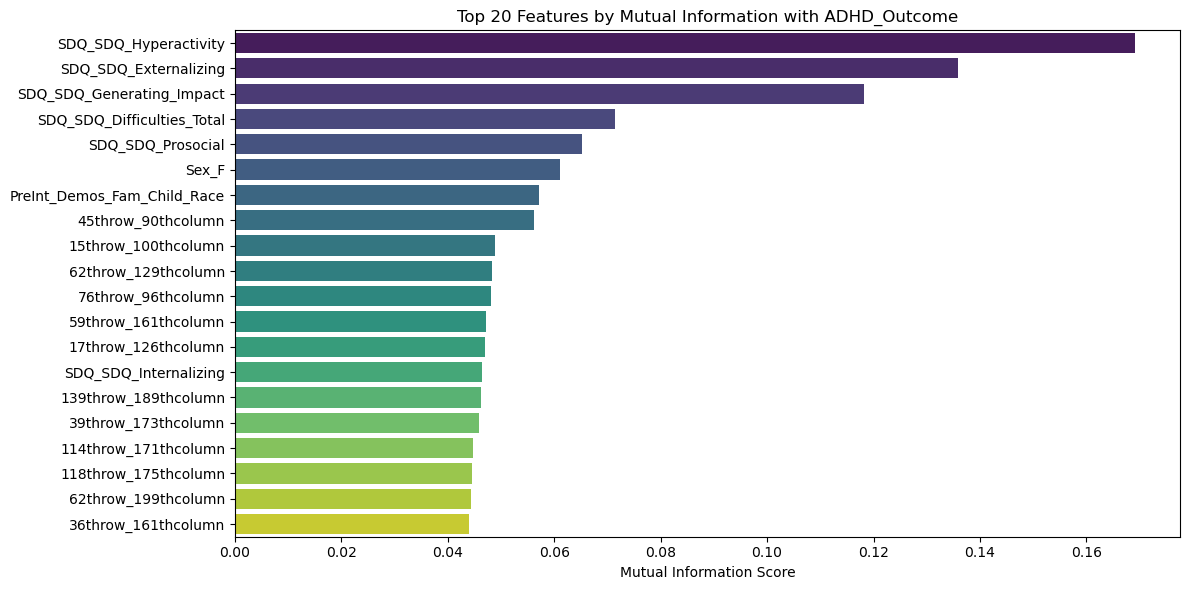


Top 10 Mutual Information scores for ADHD_Outcome:
SDQ_SDQ_Hyperactivity          0.169130
SDQ_SDQ_Externalizing          0.135805
SDQ_SDQ_Generating_Impact      0.118153
SDQ_SDQ_Difficulties_Total     0.071382
SDQ_SDQ_Prosocial              0.065287
Sex_F                          0.061046
PreInt_Demos_Fam_Child_Race    0.057059
45throw_90thcolumn             0.056212
15throw_100thcolumn            0.048791
62throw_129thcolumn            0.048405
Name: MI Scores, dtype: float64

Calculating mutual information for Sex prediction...


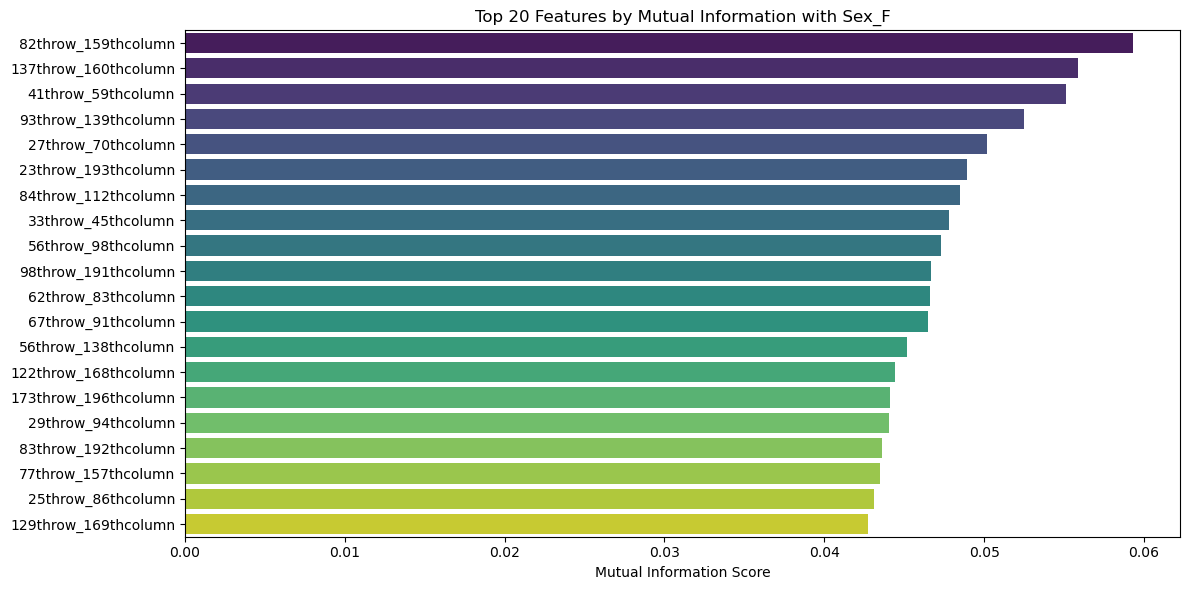


Top 10 Mutual Information scores for Sex_F:
82throw_159thcolumn     0.059288
137throw_160thcolumn    0.055848
41throw_59thcolumn      0.055118
93throw_139thcolumn     0.052513
27throw_70thcolumn      0.050183
23throw_193thcolumn     0.048899
84throw_112thcolumn     0.048514
33throw_45thcolumn      0.047773
56throw_98thcolumn      0.047273
98throw_191thcolumn     0.046663
Name: MI Scores, dtype: float64


In [16]:
# Analyze ADHD mutual information
print("\nCalculating mutual information for ADHD prediction...")
adhd_mi = analyze_mutual_information(analysis_data, 'ADHD_Outcome')
print("\nTop 10 Mutual Information scores for ADHD_Outcome:")
print(adhd_mi.head(10))

# Analyze Sex mutual information
print("\nCalculating mutual information for Sex prediction...")
sex_mi = analyze_mutual_information(analysis_data, 'Sex_F')
print("\nTop 10 Mutual Information scores for Sex_F:")
print(sex_mi.head(10))


Analyzing Sex prediction...


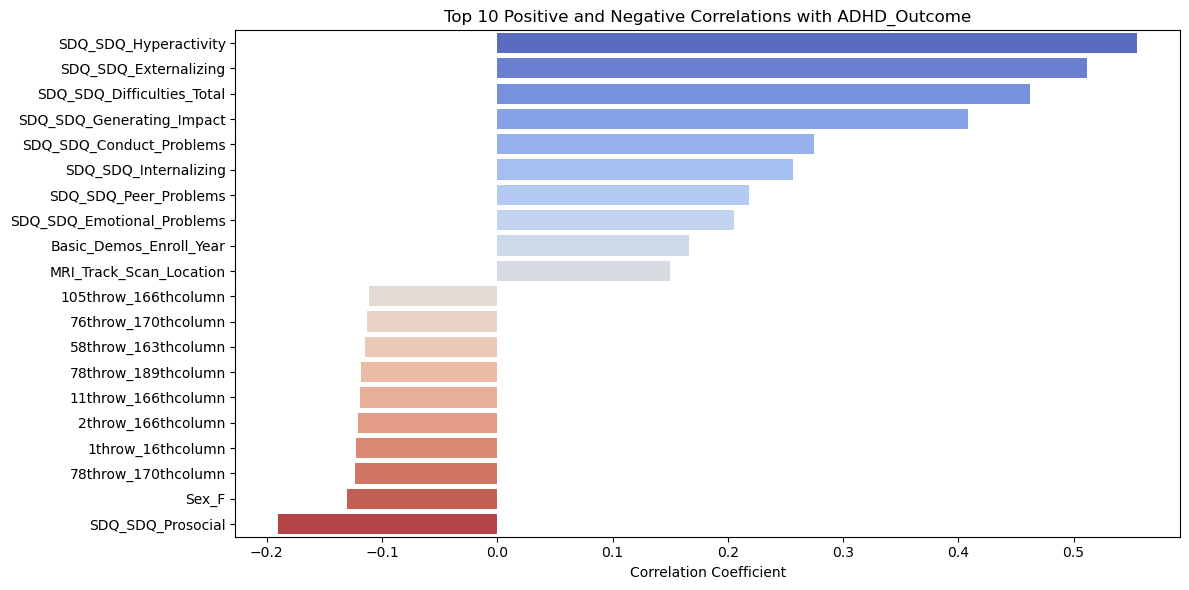


Top 10 correlations with ADHD_Outcome:
SDQ_SDQ_Hyperactivity         0.554996
SDQ_SDQ_Externalizing         0.511544
SDQ_SDQ_Difficulties_Total    0.462403
SDQ_SDQ_Generating_Impact     0.408330
SDQ_SDQ_Conduct_Problems      0.274289
SDQ_SDQ_Internalizing         0.256546
SDQ_SDQ_Peer_Problems         0.218593
SDQ_SDQ_Emotional_Problems    0.204939
Basic_Demos_Enroll_Year       0.166252
MRI_Track_Scan_Location       0.149442
dtype: float64

Bottom 10 correlations with ADHD_Outcome:
105throw_166thcolumn   -0.111699
76throw_170thcolumn    -0.112919
58throw_163thcolumn    -0.115072
78throw_189thcolumn    -0.118449
11throw_166thcolumn    -0.118818
2throw_166thcolumn     -0.120729
1throw_16thcolumn      -0.122222
78throw_170thcolumn    -0.123331
Sex_F                  -0.130836
SDQ_SDQ_Prosocial      -0.189930
dtype: float64


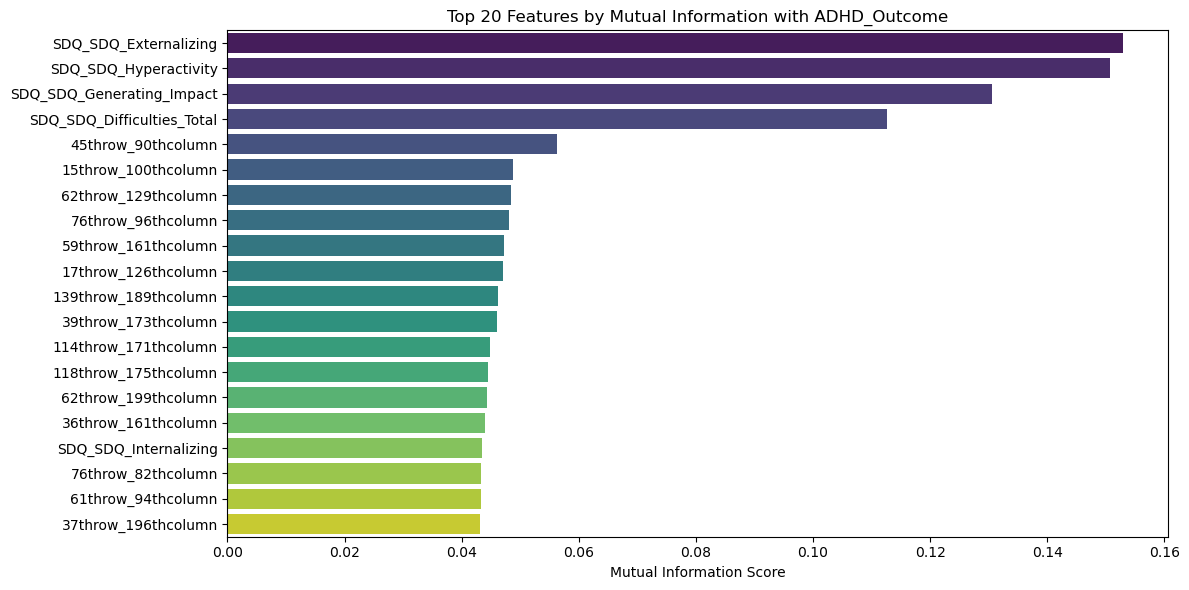


Top 10 Mutual Information scores for ADHD_Outcome:
SDQ_SDQ_Externalizing         0.152879
SDQ_SDQ_Hyperactivity         0.150626
SDQ_SDQ_Generating_Impact     0.130578
SDQ_SDQ_Difficulties_Total    0.112568
45throw_90thcolumn            0.056212
15throw_100thcolumn           0.048791
62throw_129thcolumn           0.048405
76throw_96thcolumn            0.048044
59throw_161thcolumn           0.047177
17throw_126thcolumn           0.047046
Name: MI Scores, dtype: float64


In [17]:
# Run the analysis

# Remove participant_id for analysis
print("\nAnalyzing Sex prediction...")

# Correlation analysis for ADHD
adhd_correlations = analyze_correlations(analysis_data, 'ADHD_Outcome')
print("\nTop 10 correlations with ADHD_Outcome:")
print(adhd_correlations.head(10))
print("\nBottom 10 correlations with ADHD_Outcome:")
print(adhd_correlations.tail(10))

# Mutual Information analysis for ADHD
adhd_mi = analyze_mutual_information(analysis_data, 'ADHD_Outcome')
print("\nTop 10 Mutual Information scores for ADHD_Outcome:")
print(adhd_mi.head(10))

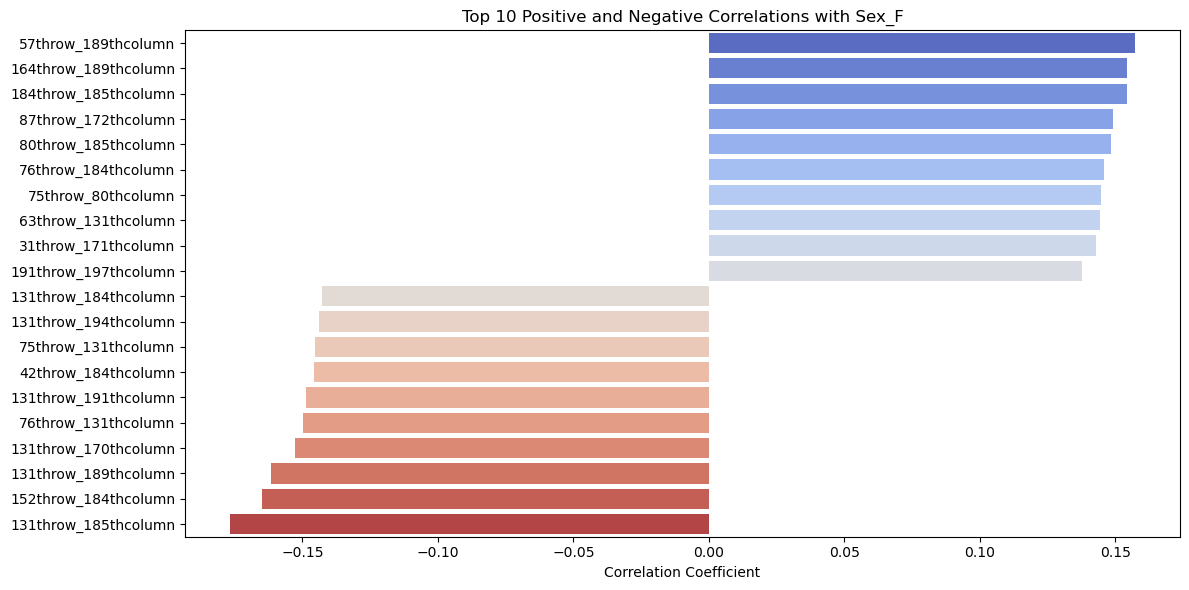


Top 10 correlations with Sex_F:
57throw_189thcolumn     0.157162
164throw_189thcolumn    0.154435
184throw_185thcolumn    0.154399
87throw_172thcolumn     0.149252
80throw_185thcolumn     0.148402
76throw_184thcolumn     0.145770
75throw_80thcolumn      0.144709
63throw_131thcolumn     0.144277
31throw_171thcolumn     0.143003
191throw_197thcolumn    0.137868
dtype: float64

Bottom 10 correlations with Sex_F:
131throw_184thcolumn   -0.142884
131throw_194thcolumn   -0.144002
75throw_131thcolumn    -0.145423
42throw_184thcolumn    -0.145723
131throw_191thcolumn   -0.148504
76throw_131thcolumn    -0.149693
131throw_170thcolumn   -0.152527
131throw_189thcolumn   -0.161591
152throw_184thcolumn   -0.164750
131throw_185thcolumn   -0.176659
dtype: float64


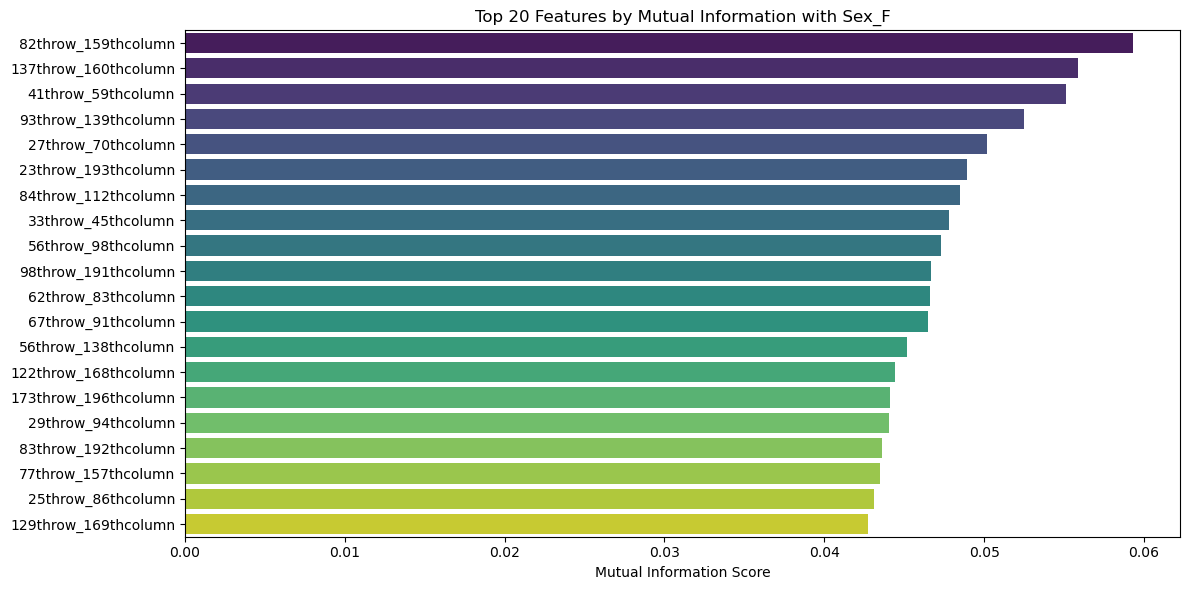


Top 10 Mutual Information scores for Sex_F:
82throw_159thcolumn     0.059288
137throw_160thcolumn    0.055848
41throw_59thcolumn      0.055118
93throw_139thcolumn     0.052513
27throw_70thcolumn      0.050183
23throw_193thcolumn     0.048899
84throw_112thcolumn     0.048514
33throw_45thcolumn      0.047773
56throw_98thcolumn      0.047273
98throw_191thcolumn     0.046663
Name: MI Scores, dtype: float64


In [18]:
# Correlation analysis for Sex
sex_correlations = analyze_correlations(analysis_data, 'Sex_F')
print("\nTop 10 correlations with Sex_F:")
print(sex_correlations.head(10))
print("\nBottom 10 correlations with Sex_F:")
print(sex_correlations.tail(10))

# Mutual Information analysis for Sex
sex_mi = analyze_mutual_information(analysis_data, 'Sex_F')
print("\nTop 10 Mutual Information scores for Sex_F:")
print(sex_mi.head(10))

In [19]:
# Save results
results = pd.DataFrame({
    'ADHD_correlation': adhd_correlations,
    'ADHD_mutual_info': adhd_mi,
    'Sex_correlation': sex_correlations,
    'Sex_mutual_info': sex_mi})

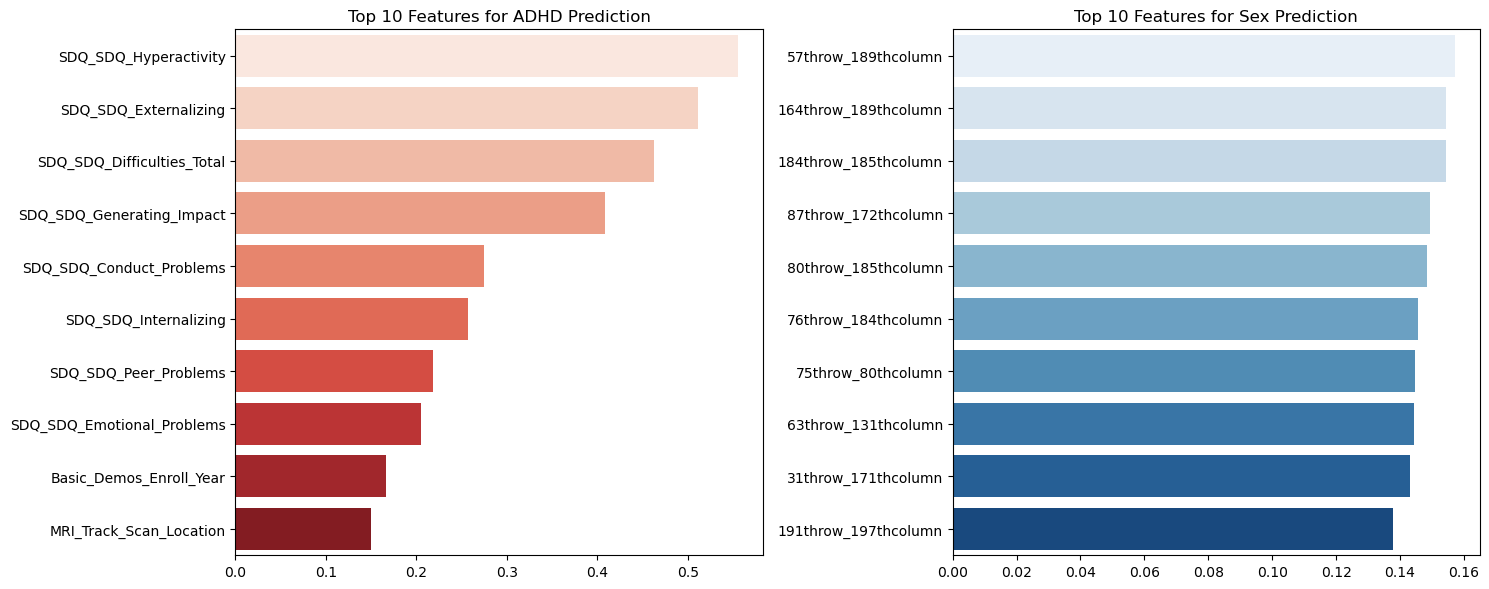

In [20]:
# Additional visualization: Compare top features for both targets
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=adhd_correlations.head(10).values,
            y=adhd_correlations.head(10).index,
            palette="Reds")
plt.title("Top 10 Features for ADHD Prediction")

plt.subplot(1, 2, 2)
sns.barplot(x=sex_correlations.head(10).values,
            y=sex_correlations.head(10).index,
            palette="Blues")
plt.title("Top 10 Features for Sex Prediction")

plt.tight_layout()
plt.show()

## Principal Component Analysis (PCA)
Perform PCA for dimensionality reduction and feature selection

Starting feature selection process...
Original shape: (1213, 19927)
Starting feature selection...
Initial shape: (1213, 19927)


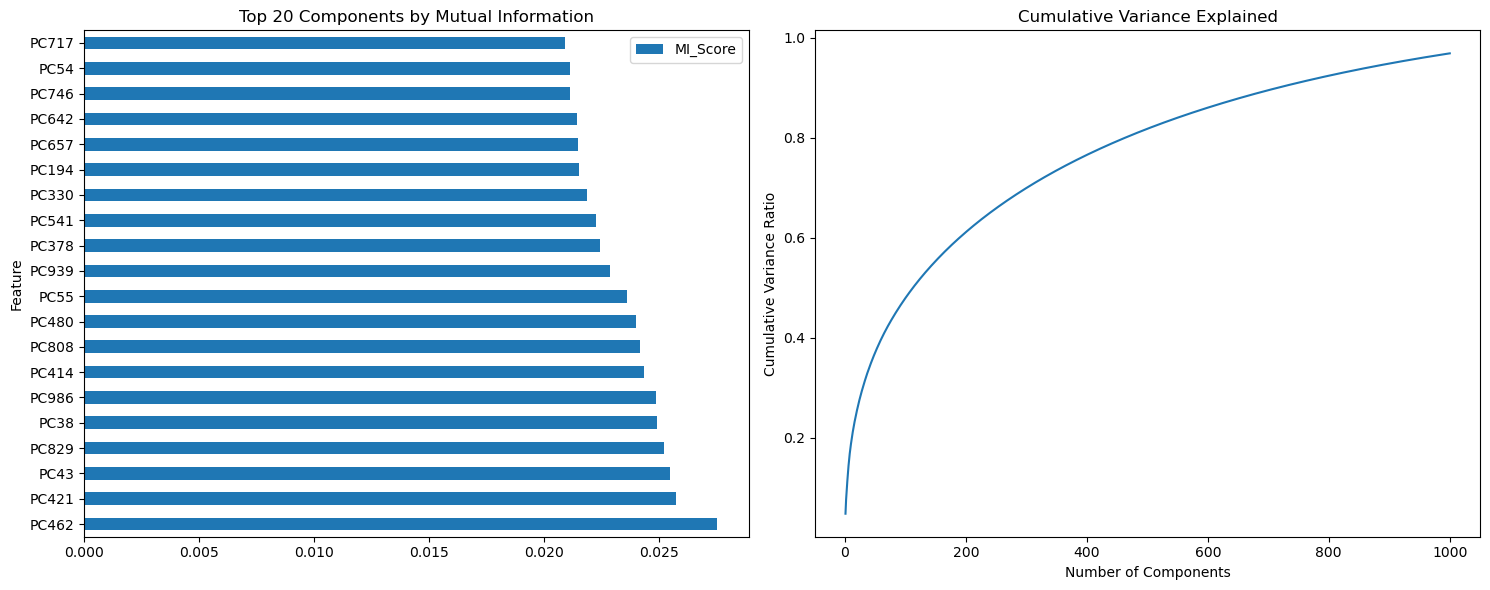


Feature selection completed
Reduced shape: (1213, 100)

Number of features selected: 100

Reduced dataset ready for preprocessing pipeline


In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def fast_feature_selection(X, y, n_features=100, method='combined'):
    """
    Efficient feature selection using PCA and/or mutual information
    
    Parameters:
    -----------
    X : DataFrame or array
        Input features
    y : DataFrame
        Target variables (ADHD_Outcome and Sex_F)
    n_features : int
        Number of features to select
    method : str
        'pca', 'mutual_info', or 'combined'
    """
    print("Starting feature selection...")
    print(f"Initial shape: {X.shape}")
    
    # Initial dimensionality reduction with PCA if there are too many features
    initial_components = min(1000, X.shape[1])  # Limit initial components
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if method == 'pca':
        # Direct PCA to n_features
        pca = PCA(n_components=n_features)
        X_reduced = pca.fit_transform(X_scaled)
        
        # Get feature names/importance for visualization
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': np.abs(pca.components_[0])  # Using first component for simplicity
        }).nlargest(20, 'Importance')
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['Feature'], feature_importance['Importance'])
        plt.title('Top 20 Features by PCA Loading (First Component)')
        plt.xlabel('Absolute Loading Value')
        plt.tight_layout()
        plt.show()
        
        return X_reduced, feature_importance['Feature'].tolist()[:n_features]
    
    elif method == 'mutual_info':
        # Calculate mutual information scores
        mi_adhd = mutual_info_classif(X_scaled, y['ADHD_Outcome'])
        mi_sex = mutual_info_classif(X_scaled, y['Sex_F'])
        
        # Combine scores
        mi_scores = (mi_adhd + mi_sex) / 2
        
        # Select top features
        top_indices = np.argsort(mi_scores)[-n_features:]
        selected_features = X.columns[top_indices]
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns[top_indices[-20:]], mi_scores[top_indices[-20:]])
        plt.title('Top 20 Features by Mutual Information')
        plt.xlabel('Mutual Information Score')
        plt.tight_layout()
        plt.show()
        
        return X_scaled[:, top_indices], selected_features.tolist()
    
    else:  # combined method
        # First reduce dimensionality with PCA
        pca = PCA(n_components=min(initial_components, X.shape[1]))
        X_pca = pca.fit_transform(X_scaled)
        
        # Calculate mutual information on reduced features
        mi_adhd = mutual_info_classif(X_pca, y['ADHD_Outcome'])
        mi_sex = mutual_info_classif(X_pca, y['Sex_F'])
        mi_scores = (mi_adhd + mi_sex) / 2
        
        # Select final features
        top_indices = np.argsort(mi_scores)[-n_features:]
        
        # Get feature importance for visualization
        feature_importance = pd.DataFrame({
            'Feature': [f'PC{i+1}' for i in range(len(mi_scores))],
            'MI_Score': mi_scores,
            'Variance_Explained': pca.explained_variance_ratio_
        })
        
        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot mutual information scores
        feature_importance.nlargest(20, 'MI_Score').plot(
            kind='barh', x='Feature', y='MI_Score', ax=ax1)
        ax1.set_title('Top 20 Components by Mutual Information')
        
        # Plot cumulative variance explained using plt directly
        cumsum_var_ratio = np.cumsum(pca.explained_variance_ratio_)
        ax2.plot(range(1, len(cumsum_var_ratio) + 1), cumsum_var_ratio)
        ax2.set_title('Cumulative Variance Explained')
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Cumulative Variance Ratio')
        
        plt.tight_layout()
        plt.show()
        
        return X_pca[:, top_indices], [f'PC{i+1}' for i in top_indices]

# Apply feature selection
try:
    # Prepare data - use numpy arrays for efficiency
    numeric_X = X.select_dtypes(include=[np.number])
    numeric_X = numeric_X.fillna(numeric_X.median())
    
    print("Starting feature selection process...")
    print("Original shape:", numeric_X.shape)
    
    # Select features
    n_features_to_select = 100
    X_reduced, selected_features = fast_feature_selection(
        numeric_X, 
        y, 
        n_features=n_features_to_select,
        method='combined'
    )
    
    print("\nFeature selection completed")
    print("Reduced shape:", X_reduced.shape)
    print("\nNumber of features selected:", len(selected_features))
    
    # Convert to DataFrame for further processing if needed
    X_reduced_df = pd.DataFrame(
        X_reduced,
        columns=[f'Feature_{i}' for i in range(X_reduced.shape[1])]
    )
    
    print("\nReduced dataset ready for preprocessing pipeline")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    print(traceback.format_exc())

Starting feature selection...
Initial shape: (1213, 19927)


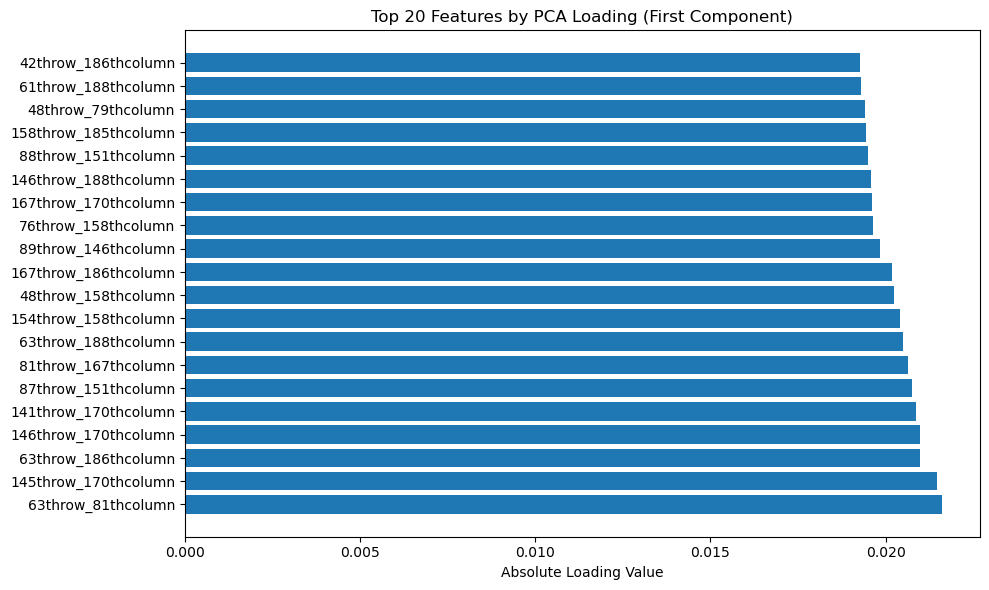

Starting feature selection...
Initial shape: (1213, 19927)


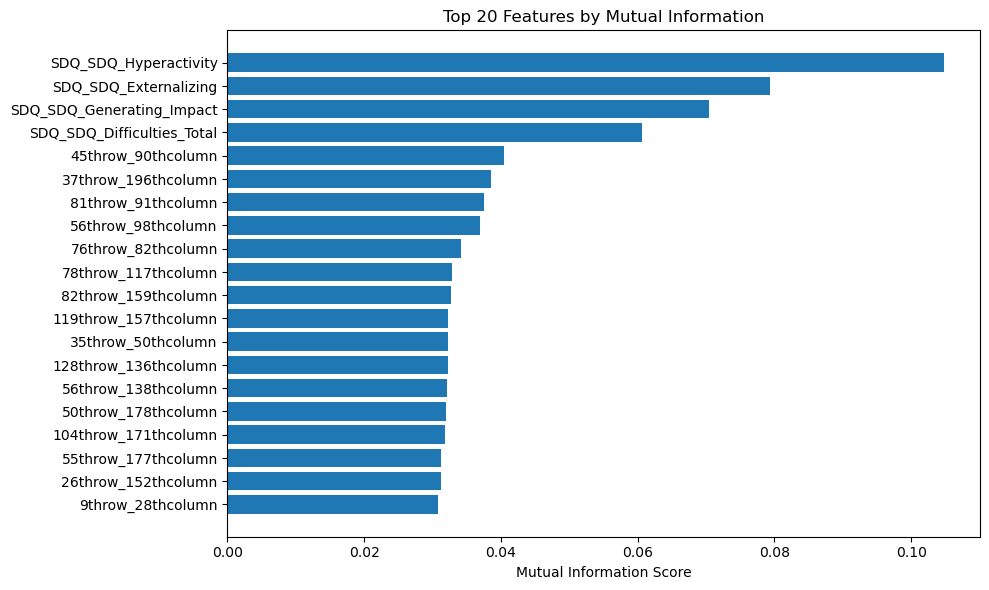

Starting feature selection...
Initial shape: (1213, 19927)


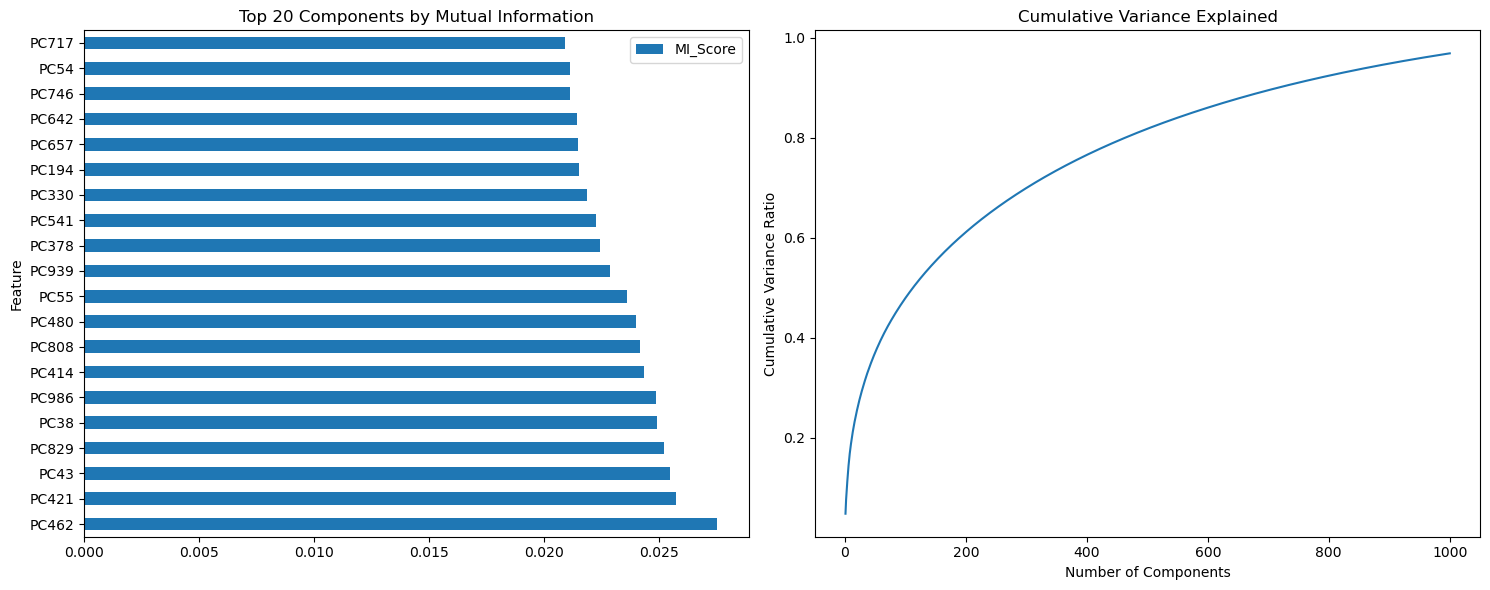

In [80]:
# For PCA-only feature selection:
X_reduced, selected_features = fast_feature_selection(numeric_X, y, n_features=100, method='pca')

# For mutual information-only feature selection:
X_reduced, selected_features = fast_feature_selection(numeric_X, y, n_features=100, method='mutual_info')

# For combined approach (recommended):
X_reduced, selected_features = fast_feature_selection(numeric_X, y, n_features=100, method='combined')

## Preprocessing Pipeline
Create preprocessing pipelines for numeric and categorical features

In [101]:
def identify_feature_types(data):
    """
    Identify categorical and numeric features from the merged dataset
    """
    # Exact categorical column names from the data
    categorical_columns = [
        'Basic_Demos_Enroll_Year',
        'Basic_Demos_Study_Site',
        'PreInt_Demos_Fam_Child_Ethnicity',
        'PreInt_Demos_Fam_Child_Race',
        'MRI_Track_Scan_Location',
        'Barratt_Barratt_P1_Edu',
        'Barratt_Barratt_P1_Occ',
        'Barratt_Barratt_P2_Edu',
        'Barratt_Barratt_P2_Occ'
    ]
    
    # Verify which categorical columns are actually in the dataset
    available_categorical = [col for col in categorical_columns if col in data.columns]
    missing_categorical = [col for col in categorical_columns if col not in data.columns]
    
    if missing_categorical:
        print("\nWarning: Some categorical columns were not found in the dataset:")
        print(missing_categorical)
    
    # All other columns (except participant_id and targets) are numeric
    numeric_columns = [col for col in data.columns 
                      if col not in categorical_columns 
                      and col != 'participant_id'
                      and col not in ['ADHD_Outcome', 'Sex_F']]
    
    print("\nFeature Type Summary:")
    print(f"Categorical Features ({len(available_categorical)}):")
    print(available_categorical)
    print(f"\nNumeric Features: {len(numeric_columns)}")
    print("Sample of numeric features:")
    print(numeric_columns[:5])
    
    return numeric_columns, available_categorical

In [115]:
def create_preprocessing_pipeline(numeric_features, categorical_features, n_components=100):
    """
    Create preprocessing pipeline with feature selection
    """
    transformers = []
    
    # Numeric pipeline with feature selection
    if len(numeric_features) > 0:
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Use median for numeric
            ('scaler', StandardScaler()),
            ('selector', PCA(n_components=n_components))
        ])
        transformers.append(('num', numeric_transformer, numeric_features))
    
    # Categorical pipeline
    if len(categorical_features) > 0:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most_frequent for categorical
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        transformers.append(('cat', categorical_transformer, categorical_features))
    
    # Combine transformers
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    
    return preprocessor


In [117]:
# Main workflow
try:
    
    # Separate features and targets
    X = merged_data_with_targets.drop(['participant_id', 'ADHD_Outcome', 'Sex_F'], axis=1)
    y = merged_data_with_targets[['ADHD_Outcome', 'Sex_F']]
    
    # Identify feature types
    numeric_features, categorical_features = identify_feature_types(X)
    
    print("\nAnalyzing categorical features before processing:")
    for col in categorical_features:
        print(f"\n{col} - Unique values:")
        print(X[col].value_counts().head())
        print(f"Missing values: {X[col].isnull().sum()}")
    
    # Create and fit preprocessing pipeline
    n_components = 100
    preprocessor = create_preprocessing_pipeline(
        numeric_features, 
        categorical_features,
        n_components=n_components
    )
    
    # Fit and transform the data
    X_processed = preprocessor.fit_transform(X)
    
    # Get feature names
    feature_names = []
    if len(numeric_features) > 0:
        feature_names.extend([f'PC{i+1}' for i in range(n_components)])
    if len(categorical_features) > 0:
        cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        feature_names.extend(cat_features)
    
    # Create processed DataFrame
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
    
    print("\nProcessing Results:")
    print(f"Original shape: {X.shape}")
    print(f"Processed shape: {X_processed.shape}")
    print("\nFeature composition:")
    print(f"PCA components: {n_components}")
    if len(categorical_features) > 0:
        print(f"One-hot encoded categorical features: {len(cat_features)}")
        print("\nSample of encoded categorical features:")
        cat_columns = [col for col in feature_names if 'PC' not in col]
        print(cat_columns[:5])
    
    # Analyze target distribution
    print("\nTarget Distribution:")
    print("ADHD Outcome:")
    print(y['ADHD_Outcome'].value_counts(normalize=True))
    print("\nSex Distribution:")
    print(y['Sex_F'].value_counts(normalize=True))
    
    # Save processed data
    processed_data = {
        'X_processed': X_processed_df,
        'y': y,
        'feature_names': feature_names,
        'preprocessor': preprocessor
    }

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    print(traceback.format_exc())


Feature Type Summary:
Categorical Features (9):
['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']

Numeric Features: 19918
Sample of numeric features:
['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']

Analyzing categorical features before processing:

Basic_Demos_Enroll_Year - Unique values:
Basic_Demos_Enroll_Year
2018    415
2019    312
2017    254
2016    191
2015     36
Name: count, dtype: int64
Missing values: 0

Basic_Demos_Study_Site - Unique values:
Basic_Demos_Study_Site
1    652
3    430
4    120
2     11
Name: count, dtype: int64
Missing values: 0

PreInt_Demos_Fam_Child_Ethnicity - Unique values:
PreInt_Demos_Fam_Child_Ethnicity
0.0    777
1.0    296
2.0     77
3.0     20
Name: count, dtype: int64
Missing values: 43

PreInt

## Feature Names and Final Dataset
Create meaningful feature names and organize the processed data

In [135]:
def create_feature_names(preprocessor, numeric_features, categorical_features, n_components):
    """
    Create meaningful feature names for the processed dataset
    """
    feature_names = []
    
    # PCA component names
    pca_names = [f'PCA_{i+1}_brain_connectivity' for i in range(n_components)]
    feature_names.extend(pca_names)
    
    # Categorical feature names (if any)
    if len(categorical_features) > 0:
        cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        categorical_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names.extend(categorical_names)
    
    return feature_names

In [137]:
def organize_processed_data(X_processed, y, feature_names):
    """
    Organize processed data into a clean DataFrame with proper feature names
    """
    # Create DataFrame with processed features
    processed_df = pd.DataFrame(
        X_processed,
        columns=feature_names
    )
    
    # Add target variables
    for col in y.columns:
        processed_df[col] = y[col]
    
    return processed_df

In [139]:
def validate_processed_dataset(processed_df, feature_names, target_cols):
    """
    Perform comprehensive validation checks on processed dataset
    """
    print("Dataset Validation Checks:")
    print("=" * 50)
    
    # Basic shape and structure
    print("\nDataset Structure:")
    print(f"Number of samples: {processed_df.shape[0]}")
    print(f"Number of features: {len(feature_names)}")
    print(f"Number of target variables: {len(target_cols)}")
    
    # Check for missing values
    missing = processed_df.isnull().sum()
    if missing.sum() > 0:
        print("\nWarning: Missing values found:")
        print(missing[missing > 0])
    else:
        print("\n✓ No missing values")
    
    # Check for infinite values
    inf_count = np.isinf(processed_df.select_dtypes(include=[np.number])).sum().sum()
    if inf_count > 0:
        print("\nWarning: Infinite values found:", inf_count)
    else:
        print("\n✓ No infinite values")
    
    # Feature statistics
    print("\nFeature Statistics:")
    print("-" * 30)
    
    # PCA components statistics
    pca_features = [f for f in feature_names if 'PCA' in f]
    if pca_features:
        print("\nPCA Components Summary:")
        pca_stats = processed_df[pca_features].describe()
        print(pca_stats.round(3))
    
    # Categorical features statistics
    cat_features = [f for f in feature_names if 'PCA' not in f]
    if cat_features:
        print("\nCategorical Features Summary:")
        for feat in cat_features[:5]:  # Show first 5 categorical features
            print(f"\n{feat}:")
            print(processed_df[feat].value_counts().head())
    
    # Target variable analysis
    print("\nTarget Variable Analysis:")
    print("-" * 30)
    for target in target_cols:
        print(f"\n{target}:")
        print("Value counts:")
        print(processed_df[target].value_counts(normalize=True))
        print("\nDescriptive statistics:")
        print(processed_df[target].describe())
    
    # Feature correlation with targets
    print("\nFeature-Target Correlations:")
    print("-" * 30)
    for target in target_cols:
        correlations = processed_df[feature_names].corrwith(processed_df[target])
        print(f"\nTop 5 features correlated with {target}:")
        print(correlations.abs().sort_values(ascending=False).head())
    
    # Data balance check
    print("\nClass Balance Check:")
    print("-" * 30)
    for target in target_cols:
        balance_ratio = processed_df[target].value_counts(normalize=True)
        print(f"\n{target} balance ratio:")
        print(balance_ratio)
        if max(balance_ratio) > 0.75:
            print(f"Warning: {target} shows class imbalance")
    
    return {
        'missing_values': missing.sum(),
        'infinite_values': inf_count,
        'feature_stats': processed_df[feature_names].describe(),
        'target_stats': processed_df[target_cols].describe()
    }

In [141]:
# Main workflow
try:
    
    # Separate features and targets
    X = merged_data_with_targets.drop(['participant_id', 'ADHD_Outcome', 'Sex_F'], axis=1)
    y = merged_data_with_targets[['ADHD_Outcome', 'Sex_F']]
    
    # Identify feature types
    numeric_features, categorical_features = identify_feature_types(X)
    
    print("\nFeature Summary:")
    print(f"Total features: {X.shape[1]}")
    print(f"Numeric features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    
    # Create and fit preprocessing pipeline
    n_components = 100
    preprocessor = create_preprocessing_pipeline(
        numeric_features, 
        categorical_features,
        n_components=n_components
    )
    
    # Fit and transform the data
    X_processed = preprocessor.fit_transform(X)
    
    # Create meaningful feature names
    feature_names = create_feature_names(preprocessor, numeric_features, categorical_features, n_components)
    
    # Create final dataset
    final_dataset = pd.DataFrame(X_processed, columns=feature_names)
    final_dataset['ADHD_Outcome'] = y['ADHD_Outcome']
    final_dataset['Sex_F'] = y['Sex_F']
    
    # Validate the processed dataset
    validation_results = validate_processed_dataset(
        final_dataset,
        feature_names,
        target_cols=['ADHD_Outcome', 'Sex_F']
    )
    
    # Save processed data
    processed_data = {
        'dataset': final_dataset,
        'feature_names': feature_names,
        'validation_results': validation_results,
        'preprocessor': preprocessor
    }
    
    print("\nProcessing and validation complete!")
    print(f"Final dataset shape: {final_dataset.shape}")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    print(traceback.format_exc())


Feature Type Summary:
Categorical Features (9):
['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']

Numeric Features: 19918
Sample of numeric features:
['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']

Feature Summary:
Total features: 19927
Numeric features: 19918
Categorical features: 9
Dataset Validation Checks:

Dataset Structure:
Number of samples: 1213
Number of features: 162
Number of target variables: 2

✓ No missing values

✓ No infinite values

Feature Statistics:
------------------------------

PCA Components Summary:
       PCA_1_brain_connectivity  PCA_2_brain_connectivity  \
count                  1213.000                  1213.000   
mean                      0.000                     0.000   
std                      30.8

## Quality Checks and Validation
Perform final checks on the processed dataset

In [143]:
def validate_processed_dataset(data, feature_names, target_cols):
    """
    Perform validation checks on processed dataset
    """
    print("Dataset Validation Checks:")
    print("=" * 50)
    
    # Check for missing values
    missing = data.isnull().sum()
    if missing.sum() > 0:
        print("\nWarning: Missing values found:")
        print(missing[missing > 0])
    else:
        print("\n✓ No missing values")
    
    # Check for infinite values
    if np.isinf(data.select_dtypes(include=[np.number])).sum().sum() > 0:
        print("\nWarning: Infinite values found")
    else:
        print("\n✓ No infinite values")
    
    # Check feature ranges
    print("\nFeature ranges:")
    print(data[feature_names].agg(['min', 'max']).T.head())
    
    # Check target variable integrity
    print("\nTarget variable checks:")
    for target in target_cols:
        print(f"\n{target}:")
        print("Unique values:", data[target].unique())
        print("Value counts:", data[target].value_counts())

# Run validation checks
validate_processed_dataset(final_dataset, feature_names, target_cols)

Dataset Validation Checks:

✓ No missing values

✓ No infinite values

Feature ranges:
                                min         max
PCA_1_brain_connectivity -82.324760  133.421856
PCA_2_brain_connectivity -64.242995  110.109719
PCA_3_brain_connectivity -82.549713   87.614420
PCA_4_brain_connectivity -54.155202   75.496905
PCA_5_brain_connectivity -56.557962   69.216505

Target variable checks:

ADHD_Outcome:
Unique values: [1 0]
Value counts: ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

Sex_F:
Unique values: [0 1]
Value counts: Sex_F
0    797
1    416
Name: count, dtype: int64
